In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/utilities_general.py"

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Union


path_prefix = "/content/drive/MyDrive/Colab Notebooks/MachineLearning_Fermibot_DimensionalityReduction"
embeddings_file_path = f"{path_prefix}/df_embeddings.pkl"

N_FEATURES = 2048
TOP_K = 10

In [ ]:
df_embeddings = pd.read_pickle(embeddings_file_path).head(512)
array_start = np.array(df_embeddings["embeddings"].to_list())

In [ ]:
class PrincipalComponentAnalysis:
    def __init__(self, X, dim_in, dim_out: Union[int, List[int]]):
        self.X = X
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.projections = {}
        self.calculate_eigen()
        self.print_formatter = print_formatter


        if type(dim_out) == int:
          self.projections[dim_out] = self.project(dim_out)
        elif type(dim_out) == list:
          for dim in dim_out:
            self.projections[dim] = self.project(dim)
        else:
          raise ValueError("dim_out must be an integer or a list of integers")



    def calculate_eigen(self):

      self.X_mean = array_start.mean(axis=1)
      self.X_std = array_start.std(axis=1)

      self.X_norm = (self.X - self.X_mean[:, np.newaxis]) / self.X_std[:, np.newaxis]
      self.X_cov = np.cov(self.X_norm, rowvar=False)

      self.X_eigen_values, self.X_eigen_vectors = np.linalg.eigh(self.X_cov)


      assert self.X_norm.shape == self.X.shape
      assert self.X_norm.shape == (len(self.X), self.dim_in)
      assert self.X_cov.shape == (self.dim_in, self.dim_in)
      assert self.X_eigen_values.shape == (self.dim_in,)
      assert self.X_eigen_vectors.shape == (self.dim_in, self.dim_in)

    def project(self, dim_out):
      self.print_formatter(f"Projecting from {self.dim_in:04} to {dim_out:04}|Start")
      if dim_out > self.dim_in:
          raise ValueError("dim_out cannot be greater than dim_in")
      self.X_eigen_index_sorted = np.argsort(self.X_eigen_values)[::-1]
      self.X_eigen_values_sorted = self.X_eigen_values[self.X_eigen_index_sorted]
      self.X_eigen_vectors_sorted = self.X_eigen_vectors[:, self.X_eigen_index_sorted]
      self.X_eigen_vectors_sorted_top_k = self.X_eigen_vectors_sorted[:, :dim_out]
      assert self.X_eigen_vectors_sorted_top_k.shape == (self.dim_in, dim_out)
      assert self.X_eigen_vectors_sorted.shape == (self.dim_in, self.dim_in)
      assert self.X_eigen_values_sorted.shape == (self.dim_in,)
      projection = self.X_norm @ self.X_eigen_vectors_sorted_top_k
      assert projection.shape == (len(self.X), dim_out)
      self.print_formatter(f"Projecting from {self.dim_in:04} to {dim_out:04}|End\n", color="green")
      return projection

    def project_all(self):
      return self.project(self.dim_out)


pca = PrincipalComponentAnalysis(array_start, N_FEATURES, [2 ** x for x in range(2, 11)])

[2025-07-24 02:42:21] Projecting from 2048 to 0004|Start
[2025-07-24 02:42:21] Projecting from 2048 to 0004|End

[2025-07-24 02:42:21] Projecting from 2048 to 0008|Start
[2025-07-24 02:42:21] Projecting from 2048 to 0008|End

[2025-07-24 02:42:21] Projecting from 2048 to 0016|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0016|End

[2025-07-24 02:42:22] Projecting from 2048 to 0032|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0032|End

[2025-07-24 02:42:22] Projecting from 2048 to 0064|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0064|End

[2025-07-24 02:42:22] Projecting from 2048 to 0128|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0128|End

[2025-07-24 02:42:22] Projecting from 2048 to 0256|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0256|End

[2025-07-24 02:42:22] Projecting from 2048 to 0512|Start
[2025-07-24 02:42:23] Projecting from 2048 to 0512|End

[2025-07-24 02:42:23] Projecting from 2048 to 1024|Start
[2025-07-24 02:42:23] Projecting from 2

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cosine_similarities = {}

def cosine_similarity_flattened(matrix):
  matrix = cosine_similarity(matrix)
  matrix_triangle_indices = np.triu_indices_from(matrix)
  matrix[matrix_triangle_indices] = np.nan
  matrix = matrix.flatten()
  matrix = matrix[~np.isnan(matrix)]
  return matrix


for dim in pca.projections.keys():
  cosine_similarities[f"PCA_{dim:04}"] = cosine_similarity_flattened(pca.projections[dim])

cosine_similarities[f"Original_2048"] = cosine_similarity_flattened(array_start)


cosine_similarities = pd.DataFrame(cosine_similarities)


path_prefix = "/content/drive/MyDrive/Colab Notebooks/MachineLearning_PrincipalComponentAnalysis"

cosine_similarities.to_csv(f"{path_prefix}/MachineLearning_PrincipalComponentAnalysis.csv")

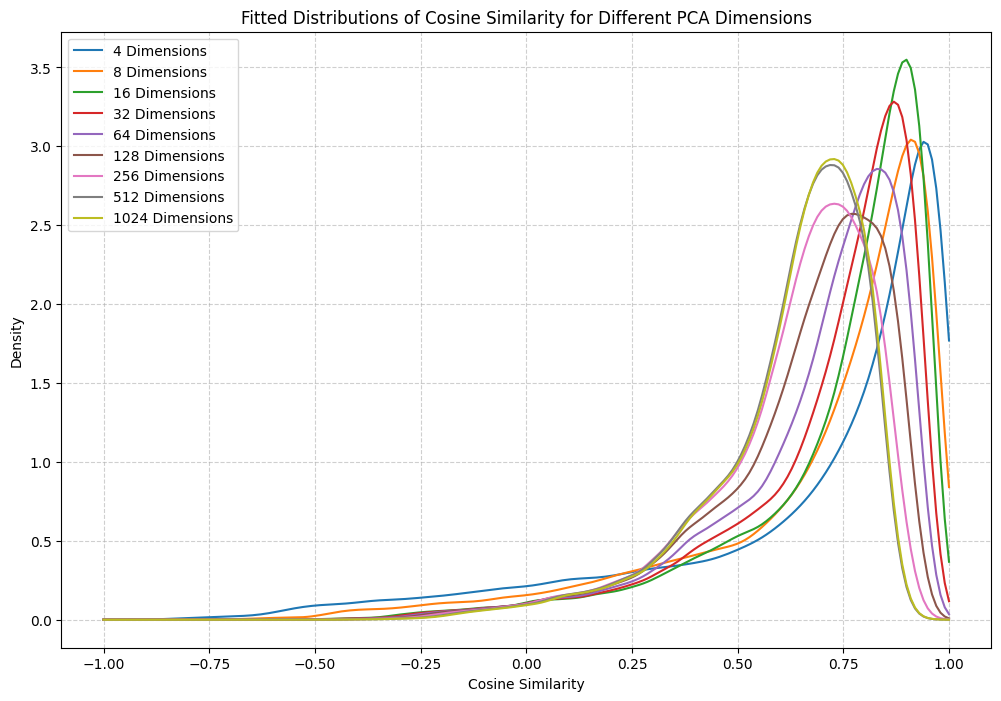

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

plt.figure(figsize=(12, 8)) # Adjust figure size for better readability

# Define a range for the x-axis for plotting the fitted curves
x_range = np.linspace(-1, 1, 200) # Cosine similarity is between -1 and 1

for dim, cosine_sim_matrix in cosine_similarities.items():
  # Flatten the cosine similarity matrix and remove NaN values
  data_hist = cosine_sim_matrix[~np.isnan(cosine_sim_matrix)].flatten()

  # Use a larger number of bins for KDE estimation
  kde = gaussian_kde(data_hist, bw_method='silverman') # Using 'scott' or 'silverman' can help with bandwidth selection
  pdf = kde(x_range)

  # Plot the fitted curve
  plt.plot(x_range, pdf, label=f'{dim} Dimensions') # Plot the PDF curve

plt.title('Fitted Distributions of Cosine Similarity for Different PCA Dimensions')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend() # Add a legend to identify dimensions
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability
plt.show()

In [ ]:
# Calculate cosine similarity for the original array_start
original_cosine_sim = cosine_similarity(array_start)

# Create a dictionary to store the difference matrices
similarity_differences = {}

# Subtract the PCA projection similarity matrices from the original
for dim, pca_cosine_sim_matrix in cosine_similarities.items():
  # Ensure both matrices have the same shape (they should)
  if original_cosine_sim.shape == pca_cosine_sim_matrix.shape:
    # Subtract the PCA similarity matrix from the original
    similarity_differences[dim] = original_cosine_sim - pca_cosine_sim_matrix
  else:
    print(f"Warning: Shape mismatch for dimension {dim}. Skipping subtraction.")


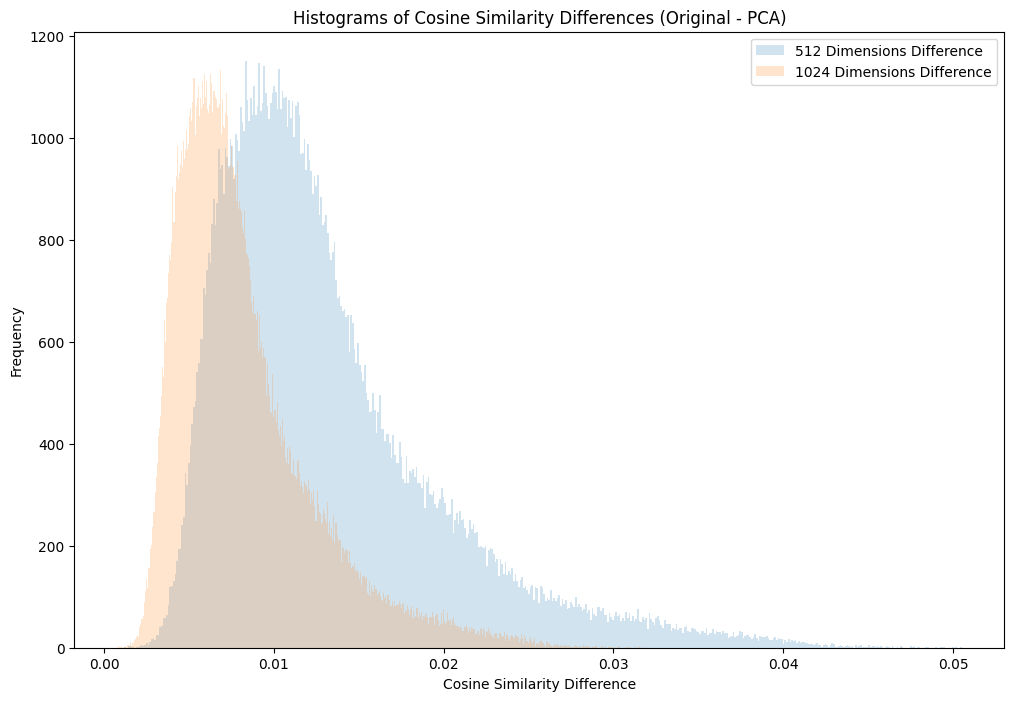

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8)) # Adjust figure size for better readability

for dim, diff_matrix in similarity_differences.items():
  if dim > 256:
    # Flatten the difference matrix and remove NaN values
    data_hist = diff_matrix[~np.isnan(diff_matrix)].flatten()

    # Create a histogram for each dimension's differences with many bins
    plt.hist(data_hist, bins=500, alpha=0.2, label=f'{dim} Dimensions Difference')

plt.title('Histograms of Cosine Similarity Differences (Original - PCA)')
plt.xlabel('Cosine Similarity Difference')
plt.ylabel('Frequency')
plt.legend() # Add a legend to identify dimensions
plt.show()